In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import folium

import json
from pathlib import Path
import pymap3d
from datetime import datetime

import pandas as pd

In [2]:
f_path = Path('../data/routes/chernivtsi/eway/trolbus/trolbus_11.json')

with open(str(f_path), 'r') as f:
    data = json.load(f)

data.keys()

dict_keys(['general', 'stops', 'scheme', 'begin', 'end', 'intervals'])

In [3]:
m = folium.Map(
    location=np.mean([[p['x'], p['y']]for p in data['stops']['forward']], axis=0), 
    zoom_start=12, height='90%', width='55%'
    )

for coord in data['stops']['forward']:
    folium.Circle(
        location=[ coord['x'], coord['y'] ], fill_color='#43d9de', 
        radius=16, popup=f"{coord['i']}) {coord['n']}"
    ).add_to( m )
    
folium.PolyLine(
    locations=[[float(l) for l in p.split(',')] 
               for p in data['scheme']['forward'].split(' ')], 
    color='#43d9de'
    ).add_to( m )
    
# for coord in data['stops']['backward']:
#     folium.Circle(location=[ coord['x'], coord['y'] ], 
#                   fill_color='green', 
#                   radius=8,
#                  popup=f"{coord['i']}) {coord['n']}"
#                  ).add_to( m )
# folium.PolyLine(
#     locations=[[float(l) for l in p.split(',')] 
#                for p in data['scheme']['backward'].split(' ')], 
#     color='green'
#     ).add_to( m )

m

In [4]:
forward_route = [[float(l) for l in p.split(',')] 
                 for p in data['scheme']['forward'].split(' ')]
forward_route_np = np.array(forward_route)

CHERNIVTSI_CENTER = np.array([48.3, 25.933333])
CHERNIVTSI_CENTER, forward_route_np.shape


(array([48.3     , 25.933333]), (458, 2))

In [87]:

class RouteENU:
    def __init__(self, route_geod: np.array, center: np.array):
        self.route_enu = None
        mask = np.append([True],np.linalg.norm(np.diff(route_geod,axis=0),axis=1) > 1e-8)
        self.route_geod = route_geod[mask]
        self.center = center
        self.ellipsoid = pymap3d.ellipsoid.Ellipsoid('wgs84')

        self.process_route()
        
        self.unit_vec = np.diff(self.route_enu, axis=0, n=1)
        self.segment_length = np.linalg.norm(self.unit_vec, axis=1)
        self.unit_vec /= self.segment_length[:, None]
        self.cumulative_length = np.append(0, np.cumsum(r.segment_length))

    def __len__(self) -> int:
        return len(self.route_geod)

    def convert_to_enu(self, coord_geod: np.array) -> np.array:
        e, n, u = pymap3d.geodetic2enu(
            lat=coord_geod[0], lon=coord_geod[1], h=0,
            lat0=self.center[0], lon0=self.center[1], h0=0,
            ell=self.ellipsoid, deg=True)

        return np.array([e, n])

    def convert_to_geod(self, coord_geod: np.array) -> np.array:
        res = pymap3d.enu2geodetic(
            e=coord_geod[:, 0], 
            n=coord_geod[:, 1], 
            u=np.zeros_like(coord_geod[:, 0]),
            lat0=self.center[0], 
            lon0=self.center[1], 
            h0=0, ell=self.ellipsoid, deg=True
        )

        return np.dstack([res[0], res[1]])[0]
    
    def optimize_route(self, points: np.array, min_dist:float = 10) -> np.array:
        opt_route = [points[0]]
        i = 0
        
        while i < len(points[:-1, :]):
            c1 = points[i, :]
            j = 0
            dist = np.linalg.norm(points[i+j, :] - c1)
            while j < len(points[i+1:, :]) and dist < min_dist:
                j += 1
                dist = np.linalg.norm(points[i+j, :] - c1)
                
            if np.linalg.norm(points[i + max(1, j-1), :] - c1) > 1e-2:
                opt_route += [points[i + max(1, j-1), :]]
            i += max(1, j-1)

        return np.array(opt_route)
    
    def proj_on_segment_cos_value(self, seg_num: int, point: np.array) -> float:
        vec2point = point - self.route_enu[seg_num]
        return vec2point.dot(self.unit_vec[seg_num])
    
    def is_on_segment(self, seg_num: int, point: np.array) -> bool: 
        proj_cos_value = self.proj_on_segment_cos_value(seg_num, point)
        return proj_cos_value > 0 and proj_cos_value <= self.segment_length[seg_num]
    
    def get_proj_on_seg_data(self, seg_num: int, point: np.array) -> dict:
        """
        https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Vector_formulation
        """
        if not self.is_on_segment(seg_num, point):
            return None
        
        point2start = point - self.route_enu[seg_num]
        proj_vec = - point2start.dot(self.unit_vec[seg_num])*self.unit_vec[seg_num]
        tang_vec = point2start + proj_vec 
        
        return {"proj_vec": proj_vec,
                "proj_length": np.linalg.norm(proj_vec),
                "tang_vec": tang_vec,
                "distance_to_line": np.linalg.norm(tang_vec), 
                "proj_point" : self.route_enu[seg_num] - proj_vec, 
                "progress" : self.cumulative_length[seg_num] + np.linalg.norm(proj_vec)
               }
    
    def get_proj_on_route(self, point: np.array) -> dict:
        result = dict()
        
        seg_proj = list()
        for seg_n, _ in enumerate(r.unit_vec):
            res = self.get_proj_on_seg_data(seg_n, point)
            if res is not None:
                res['segment_number'] = seg_n
                seg_proj.append(res)
                
        if seg_proj: 
            result["segment_projection"] = sorted(seg_proj, key=lambda x: x['distance_to_line'] )[0]
        else: 
            result["segment_projection"] = None
            
        dists2points = np.linalg.norm(r.route_enu - point, axis=1)
        
        result["optimal_point_dist"] = {"point_number": dists2points.argmin(),
                                        "dist_to_point": dists2points[dists2points.argmin()], 
                                        "progress" : self.cumulative_length[dists2points.argmin()]
                                       }
        result["route_bounds_dist"] = {'start': dists2points[0], 
                                       'end' : dists2points[-1]}
        
        return result  
    
    def process_route(self, min_dist:float=50) -> None:
        self.route_enu = [self.convert_to_enu(point) for point in self.route_geod]
        self.route_enu = self.optimize_route(np.array(self.route_enu), min_dist)
        self.route_geod = self.convert_to_geod(self.route_enu)
        
        
r = RouteENU(forward_route_np, CHERNIVTSI_CENTER)
len(r), r.route_enu.shape, r.route_geod.shape, forward_route_np.shape

(228, (228, 2), (228, 2), (458, 2))

In [12]:
r.cumulative_length.shape

(228,)

In [368]:
mx_dist = 50

m = folium.Map(
    location=np.mean([[p['x'], p['y']]for p in data['stops']['forward']], axis=0), 
    zoom_start=12, height='90%', width='55%'
    )

opt_route =  optimize_route(r.route_enu[:], mx_dist)

print(f"{opt_route.shape} - {r.route_enu.shape}")
    
# for coord in r.convert_to_geod(opt_route):
#     folium.Circle(location=[ coord[0], coord[1] ], 
#                   color='blue', 
#                   radius=4,
#                  ).add_to( m )
#     folium.Circle(location=[ coord[0], coord[1] ], 
#                   color='green', 
#                   radius=mx_dist,
#                  ).add_to( m )
    
# for coord in forward_route_np:
#     folium.Circle(location=[ coord[0], coord[1] ], 
#                   color='red', 
#                   radius=1,
#                  ).add_to( m )
# folium.PolyLine(
#     locations=r.convert_to_geod(opt_route), 
# #     locations=opt_route,
    
#     color='red'
# #     ).add_to( m )
folium.PolyLine(
#     locations=r.convert_to_geod(opt_route), 
    locations=r.route_geod, axis=0,
    color='green'
    ).add_to( m )

# {'proj_vec': array([39.40816411, 11.59206913]), 
#  'proj_length': 41.07772467940181, 
#  'tang_vec': array([  541.09231224, -1839.48649707]), 
#  'distance_to_line': 1917.417915656256, 
#  'proj_point': array([-413.97598403, 1888.60396833])}
for seg_n, _ in enumerate(r.unit_vec):
    res = r.get_proj_on_seg_data(seg_n, CHERNIVTSI_CENTER)
    if res is not None:
#         print(f"{seg_n:03}) {res}")
        folium.PolyLine(
            locations=r.convert_to_geod(np.vstack([res['proj_point'], CHERNIVTSI_CENTER])), 
#             axis=0,
            color='orange'
        ).add_to(m)

m

(228, 2) - (228, 2)


In [311]:
CHERNIVTSI_CENTER

array([48.3     , 25.933333])

In [13]:
r.get_proj_on_route(CHERNIVTSI_CENTER)

{'segment_projection': {'proj_vec': array([-21.02849539,  12.86515633]),
  'proj_length': 24.651772063501046,
  'tang_vec': array([38.77126339, 63.37282754]),
  'distance_to_line': 74.29216739280287,
  'proj_point': array([  9.52873661, -37.43949454]),
  'progress': 9372.396062267984,
  'segment_number': 182},
 'optimal_point_dist': {'point_number': 183,
  'dist_to_point': 76.90600224864839,
  'progress': 9392.27587730608},
 'route_bounds_dist': {'start': 5207.455810305489, 'end': 810.1223530386083}}

In [377]:
# [p for p in Path("../data/local/tables/data_for_03_OCT_2022.csv").iterdir() ]

In [16]:
df = pd.read_csv("../data/local/tables/data_for_03_OCT_2022.csv")

In [26]:
df[(df['routeName'] == "11")| (df['routeName'] == "11/3") ][['imei', 'routeName']].value_counts()

imei             routeName
355227046453528  11           4240
355227045540192  11           3539
355227045540572  11           3225
355227046451167  11           2981
355227045600178  11/3         2825
355227045541208  11            810
355227045541257  11            370
355227045598570  11            188
355227044854818  11             96
355227045369527  11             57
dtype: int64

In [61]:
def rgb_to_hex(r, g, b):
    return f'{r:02x}{g:02x}{b:02x}'


def plot_coloured_route(route, folium_map, color_map=mpl.cm.get_cmap('jet'), bins=10):
    bins = min(bins, len(route))
    
    lspace = np.linspace(0, len(route), num=bins+1, dtype=int)
    
    for i, (lb, rb) in enumerate(zip(lspace[:-1], lspace[1:]) ):
        clr = rgb_to_hex(*tuple(map(lambda x : int(x*255), color_map(i/bins) ))[:3])
        folium.PolyLine(
            route[lb:rb+1, :],
            color=f"#{clr}", weight=2,
            opacity=0.8
        ).add_to(folium_map)

In [ ]:
355227046453528  11           4240
355227045540192  11           3539
355227045540572  11           3225
355227046451167  11           2981
355227045600178  11/3         2825
355227045541208  11            810
355227045541257  11            370
355227045598570  11            188
355227044854818  11             96
355227045369527  11             57

In [97]:
# updata_tm = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp() for dt in sum_df['gpstime'].unique() ]
# updata_tm_np = np.array(updata_tm)

gps_data = df[df['imei'] == 355227045600178][['lat', 'lng', 'gpstime']].values
gps_data[:, 2] = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp() for dt in gps_data[:, 2] ]
gps_data = gps_data.astype(float)

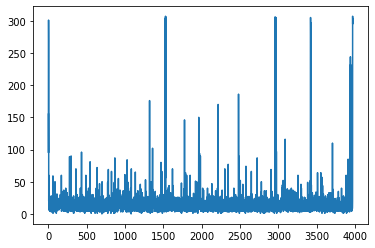

In [64]:
plt.plot(np.diff(gps_data[:, 2]))

In [65]:
np.diff(gps_data[:, 2])[np.diff(gps_data[:, 2]) <= 0 ]

array([0.0, 0.0], dtype=object)

In [66]:
trace = gps_data[:, :2]

m = folium.Map(
    location=np.mean(trace, axis=0), 
    zoom_start=12, height='50%', width='55%'
    )

plot_coloured_route(trace, m)

m

In [67]:
import time

In [83]:
from tqdm import tqdm

In [114]:
# r.convert_to_enu(gps_data[:, :2])
r.convert_to_enu(gps_data[0, :2])

array([ 4346.42917267, -3739.89608741])

In [116]:
dists = [None] * len(gps_data)

st = time.perf_counter()

for i, coord in tqdm(enumerate(gps_data[:, :2])):
    dists[i] = r.get_proj_on_route(r.convert_to_enu(coord))

end = time.perf_counter()
print(f"{end - st}")

3974it [00:03, 1223.63it/s]

3.2503603999994084


In [122]:
dists[1222]

{'segment_projection': {'proj_vec': array([18.04428989,  8.25786063]),
  'proj_length': 19.844108943651754,
  'tang_vec': array([-19.54537873,  42.70869846]),
  'distance_to_line': 46.96865714388012,
  'proj_point': array([3047.9980485 , 2888.12250824]),
  'progress': 2781.957502801704,
  'segment_number': 55},
 'optimal_point_dist': {'point_number': 55,
  'dist_to_point': 50.988659657485414,
  'progress': 2762.113393858052},
 'route_bounds_dist': {'start': 2493.114053953058, 'end': 4960.908746880177}}

In [105]:
[r['optimal_point_dist'] for r in dists[2000:2005]]

[{'point_number': 183,
  'dist_to_point': 76.90427562820447,
  'progress': 9392.27587730608},
 {'point_number': 183,
  'dist_to_point': 76.90459437200293,
  'progress': 9392.27587730608},
 {'point_number': 183,
  'dist_to_point': 76.90491270252264,
  'progress': 9392.27587730608},
 {'point_number': 183,
  'dist_to_point': 76.90529474104751,
  'progress': 9392.27587730608},
 {'point_number': 183,
  'dist_to_point': 76.90566905403128,
  'progress': 9392.27587730608}]

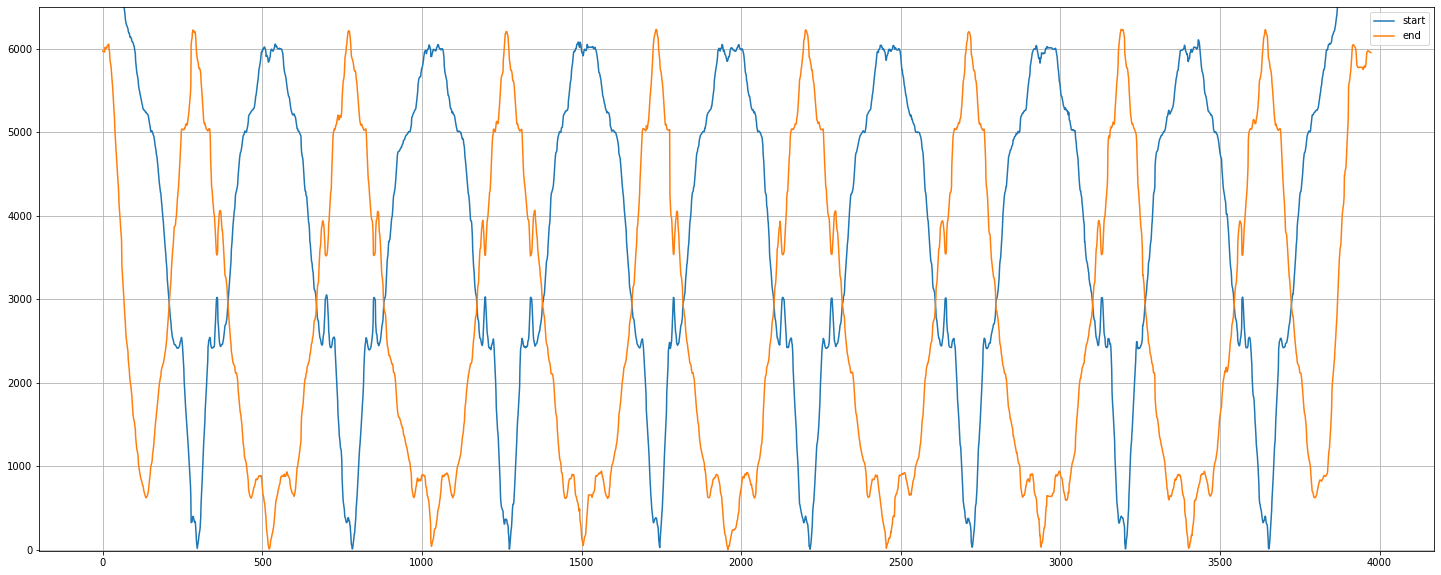

In [141]:
plt.figure(figsize=(25, 10))
plt.plot([r['route_bounds_dist']['start'] for r in dists], label='start')
plt.plot([r['route_bounds_dist']['end'] for r in dists], label='end')
plt.ylim(-10, 6500)
plt.legend()
plt.grid()

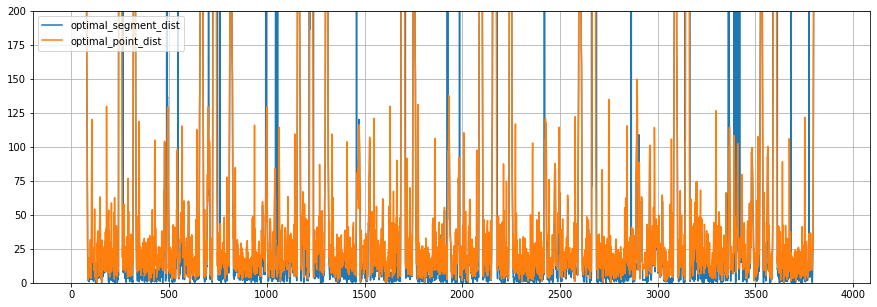

In [134]:
plt.figure(figsize=(15, 5))
lb, rb = 0, -1
plt.plot([r['segment_projection']['distance_to_line'] 
          for r in dists[lb:rb] if r['segment_projection'] is not None], 
        label = "optimal_segment_dist")
plt.plot([r['optimal_point_dist']['dist_to_point'] 
          for r in dists[lb:rb] if r['segment_projection'] is not None], 
        label = "optimal_point_dist")
plt.ylim(0, 200)

plt.grid()
plt.legend()